### Overview
The dataset consists of a network of political blogs first compiled for the study “The Political Blogosphere and the 2004 US Election” by Lada A. Adamic and Natalie Glance. It includes 1,490 nodes, each representing a blog, and an edge list indicating hyperlinks between them. Each blog has a binary political label (0 or 1), denoting its political orientation. The dataset reflects the assumption that blogs with the same political stance are more likely to link to each other, forming distinct communities. The graph is undirected. The goal is to use spectral clustering to group blogs based on their political orientation by examining the clustering structure and measuring the mismatch rate between clusters and true labels.



In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.cluster import KMeans
from collections import defaultdict
import matplotlib.pyplot as plt

The dataset is loaded, where nodes.txt contains information about each blog and its political orientation, and edges.txt contains connections between blogs. The edge_arr stores these relationships as an adjacency list, while political_label holds the ground-truth labels.

In [2]:
node_df = pd.read_csv('nodes.txt', sep="\t", header=None)
edge_arr = np.loadtxt('edges.txt', delimiter = '\t').astype(int)
political_label = np.array(node_df[2])

print("Edge array:\n", edge_arr)
print("\n True political labels:\n", political_label)


Edge array:
 [[ 267 1394]
 [ 267  483]
 [ 267 1051]
 ...
 [1133 1423]
 [1133 1408]
 [1133 1152]]

 True political labels:
 [0 0 0 ... 1 1 1]


A function is defined to construct an adjacency matrix from the edge list. The matrix A represents blog connections, where A[i, j] = 1 if blog i links to blog j.

In [3]:
def construct_adj_matrix(edge_array, number_of_nodes):
    
    A = np.zeros((number_of_nodes+1,number_of_nodes+1))
    for i in edge_array:
        A[i[0],i[1]] = 1
        A[i[1],i[0]] = 1
    return A

Isolated nodes (blogs with no connections) are removed from the adjacency matrix, and the indices of remaining nodes are stored. This helps focus on the largest connected component.

In [4]:
#removing isolated nodes and making a record of the index of non-isolated nodes
def remove_isolated_nodes(A):

    non_isolated_nodes_idx = np.where(np.sum(A, axis= 1)>0)[0] 

    A = A[:,~np.all(A == 0, axis = 0)]
    A = A[~np.all(A == 0, axis = 1),:]

    return (A, non_isolated_nodes_idx)


The normalized Adjacency matrix B is computed, which scales the adjacency matrix using the degree matrix D. This normalization helps spectral clustering perform better.

In [5]:
def construct_B(A):
    D = np.diag(1/np.sqrt(np.sum(A, axis=1)))
    B = D @ A @ D
    return B


The k largest eigenvectors from matrix B are extracted, which serve as low-dimensional embeddings of the nodes for clustering.

In [6]:
def k_largest_eigenvector(B, k):
    v, eig_vec= np.linalg.eig(B)
    idx_sorted = np.argsort(v) # the index of eigenvalue sorted acsending

    eig_vec = eig_vec[:, idx_sorted[-k:]] # select the k largest eigenvectors

    eig_vec = eig_vec/np.repeat(np.sqrt(np.sum(eig_vec*eig_vec, axis=1).reshape(-1, 1)), k, axis=1)

    return eig_vec

The get_cluster_nodes function assigns nodes to their respective clusters based on k-means results, storing them in a dictionary.

The get_cluster_labels function retrieves the true labels of nodes within each cluster. The output is a dictionary. The keys in the dict are the cluster names (e.g., "Cluster 1", "Cluster 2", etc.), while the values are arrays containing the true labels of the nodes (array of 0 and 1).


Then, the mismatch rate for each cluster is calculated by determining how many nodes differ from the majority political label in that cluster.

Finally, the overall mismatch rate is computed by weighting cluster mismatch rates by their sizes.

In [7]:
def get_cluster_nodes(cluster_idx, k, non_isolated_nodes):
    cluster_nodes_dict = defaultdict(int)
    for i in range(0,k):
        cluster_nodes_dict[f"Cluster {i+1}"] =  non_isolated_nodes[np.where(cluster_idx == i)[0]]
    return cluster_nodes_dict

def get_cluster_labels(cluster_nodes_dict, node_political_label):
    cluster_labels_dict = defaultdict(int)
    for key,val in cluster_nodes_dict.items():
        cluster_labels_dict[key] = node_political_label[val-1]
    return cluster_labels_dict

def calculate_mismatch_rate(cluster_labels_dict):
    mismatch_rate_list = []
    cluster_population = []
    majority_label_list = []
    for key, val in cluster_labels_dict.items():

        if len(val) > 1:

            cluster_population.append(len(val))
            unique, counts = np.unique(val, return_counts=True)
            if len(unique) == 2:
            
                majority_idx = np.argmax(counts)
                majority_label = unique[majority_idx]
                total = np.sum(counts)
                min = np.min(counts)
                mismatch_rate = min/total

            elif len(unique) == 1:
            
                
                majority_label = unique[0]

                mismatch_rate = 0
            





        mismatch_rate_list.append(mismatch_rate)
        majority_label_list.append(majority_label)
    return mismatch_rate_list, cluster_population,majority_label_list

def overall_mismatch_rate(mismatch_rate_list,cluster_population):
    total_mismatch_rate = np.dot(mismatch_rate_list,cluster_population)/np.sum(cluster_population)
    return total_mismatch_rate


This function integrates all previous steps to perform spectral clustering and compute the mismatch rate.

In [8]:
def spectrual_clustering_mismatch_rate(edge_arr, node_political_label, number_of_cluster):
    
    A = construct_adj_matrix(edge_arr, len(node_political_label))
    
    A, non_isolated_nodes = remove_isolated_nodes(A)
    
    B = construct_B(A)
    k = number_of_cluster

    eig_vec = k_largest_eigenvector(B, k)
 

    kmeans = KMeans(n_clusters=k, random_state= 1).fit(eig_vec.real)

    cluster_idx = kmeans.labels_

    cluster_nodes_dict = get_cluster_nodes(cluster_idx, k, non_isolated_nodes)

    cluster_labels_dict = get_cluster_labels(cluster_nodes_dict, node_political_label)

    mismatch_rate_list, cluster_population, majority_label_list = calculate_mismatch_rate(cluster_labels_dict)

    total_mismatch_rate = overall_mismatch_rate(mismatch_rate_list,cluster_population)

    return mismatch_rate_list, cluster_population, majority_label_list, total_mismatch_rate




### Testing different number of clusters

In [9]:
k = 2

mismatch_rate, nodes_num, maj_lab, total_mismatch_rate = spectrual_clustering_mismatch_rate(edge_arr, political_label, k)
for i in range(1, len(mismatch_rate)+1):
    print("cluster",i)
    print("mismatch rate:",round(mismatch_rate[i-1],4))
    print("majority label:",maj_lab[i-1])
    print("number of nodes:",nodes_num[i-1],'\n')

    

cluster 1
mismatch rate: 0.4795
majority label: 1
number of nodes: 1222 

cluster 2
mismatch rate: 0
majority label: 0
number of nodes: 2 



In [10]:
k = 5

mismatch_rate, nodes_num, maj_lab, total_mismatch_rate = spectrual_clustering_mismatch_rate(edge_arr, political_label, k)
for i in range(1, len(mismatch_rate)+1):
    print("cluster",i)
    print("mismatch rate:",round(mismatch_rate[i-1],4))
    print("majority label:",maj_lab[i-1])
    print("number of nodes:",nodes_num[i-1],'\n')

cluster 1
mismatch rate: 0.0253
majority label: 0
number of nodes: 79 

cluster 2
mismatch rate: 0.0255
majority label: 1
number of nodes: 588 

cluster 3
mismatch rate: 0.0212
majority label: 0
number of nodes: 471 

cluster 4
mismatch rate: 0.2
majority label: 1
number of nodes: 5 

cluster 5
mismatch rate: 0.4198
majority label: 1
number of nodes: 81 



In [11]:
k = 10

mismatch_rate, nodes_num, maj_lab, total_mismatch_rate = spectrual_clustering_mismatch_rate(edge_arr, political_label, k)
for i in range(1, len(mismatch_rate)+1):
    print("cluster",i)
    print("mismatch rate:",round(mismatch_rate[i-1],4))
    print("majority label:",maj_lab[i-1])
    print("number of nodes:",nodes_num[i-1],'\n')

cluster 1
mismatch rate: 0.0345
majority label: 0
number of nodes: 58 

cluster 2
mismatch rate: 0.0246
majority label: 1
number of nodes: 366 

cluster 3
mismatch rate: 0.0208
majority label: 0
number of nodes: 96 

cluster 4
mismatch rate: 0.119
majority label: 0
number of nodes: 42 

cluster 5
mismatch rate: 0.439
majority label: 0
number of nodes: 41 

cluster 6
mismatch rate: 0.4286
majority label: 1
number of nodes: 7 

cluster 7
mismatch rate: 0.4706
majority label: 1
number of nodes: 51 

cluster 8
mismatch rate: 0.0216
majority label: 0
number of nodes: 324 

cluster 9
mismatch rate: 0.0229
majority label: 1
number of nodes: 218 

cluster 10
mismatch rate: 0.0476
majority label: 0
number of nodes: 21 



In [12]:
k = 30

mismatch_rate, nodes_num, maj_lab, total_mismatch_rate = spectrual_clustering_mismatch_rate(edge_arr, political_label, k)
for i in range(1, len(mismatch_rate)+1):
    print("cluster",i)
    print("mismatch rate:",round(mismatch_rate[i-1],4))
    print("majority label:",maj_lab[i-1])
    print("number of nodes:",nodes_num[i-1],'\n')

cluster 1
mismatch rate: 0
majority label: 0
number of nodes: 4 

cluster 2
mismatch rate: 0
majority label: 1
number of nodes: 25 

cluster 3
mismatch rate: 0.0233
majority label: 0
number of nodes: 43 

cluster 4
mismatch rate: 0.0595
majority label: 1
number of nodes: 84 

cluster 5
mismatch rate: 0.2222
majority label: 0
number of nodes: 18 

cluster 6
mismatch rate: 0.0633
majority label: 1
number of nodes: 79 

cluster 7
mismatch rate: 0.0652
majority label: 0
number of nodes: 46 

cluster 8
mismatch rate: 0.0533
majority label: 1
number of nodes: 75 

cluster 9
mismatch rate: 0.4
majority label: 1
number of nodes: 40 

cluster 10
mismatch rate: 0
majority label: 0
number of nodes: 25 

cluster 11
mismatch rate: 0.0566
majority label: 0
number of nodes: 53 

cluster 12
mismatch rate: 0
majority label: 0
number of nodes: 34 

cluster 13
mismatch rate: 0.0652
majority label: 1
number of nodes: 92 

cluster 14
mismatch rate: 0.0526
majority label: 0
number of nodes: 38 

cluster 15


In [13]:
k = 50

mismatch_rate, nodes_num, maj_lab, total_mismatch_rate = spectrual_clustering_mismatch_rate(edge_arr, political_label, k)
for i in range(1, len(mismatch_rate)+1):
    print("cluster",i)
    print("mismatch rate:",round(mismatch_rate[i-1],4))
    print("majority label:",maj_lab[i-1])
    print("number of nodes:",nodes_num[i-1],'\n')

cluster 1
mismatch rate: 0
majority label: 0
number of nodes: 4 

cluster 2
mismatch rate: 0.0256
majority label: 0
number of nodes: 39 

cluster 3
mismatch rate: 0.069
majority label: 1
number of nodes: 29 

cluster 4
mismatch rate: 0
majority label: 1
number of nodes: 19 

cluster 5
mismatch rate: 0
majority label: 1
number of nodes: 47 

cluster 6
mismatch rate: 0.2121
majority label: 1
number of nodes: 33 

cluster 7
mismatch rate: 0
majority label: 0
number of nodes: 9 

cluster 8
mismatch rate: 0
majority label: 1
number of nodes: 19 

cluster 9
mismatch rate: 0
majority label: 0
number of nodes: 20 

cluster 10
mismatch rate: 0.2581
majority label: 0
number of nodes: 31 

cluster 11
mismatch rate: 0.0476
majority label: 0
number of nodes: 21 

cluster 12
mismatch rate: 0
majority label: 1
number of nodes: 49 

cluster 13
mismatch rate: 0.0333
majority label: 0
number of nodes: 30 

cluster 14
mismatch rate: 0
majority label: 0
number of nodes: 42 

cluster 15
mismatch rate: 0.24

### Determining the optimal number of cluster using an elbow plot

In [14]:
overall_mismatch_rate_list = [ spectrual_clustering_mismatch_rate(edge_arr, political_label, i)[3] for i in range(2,51)]

2  clusters
Overall mismatch rate: 0.4788 

3  clusters
Overall mismatch rate: 0.4788 

4  clusters
Overall mismatch rate: 0.0466 

5  clusters
Overall mismatch rate: 0.0507 

6  clusters
Overall mismatch rate: 0.0515 

7  clusters
Overall mismatch rate: 0.0507 

8  clusters
Overall mismatch rate: 0.0547 

9  clusters
Overall mismatch rate: 0.0539 

10  clusters
Overall mismatch rate: 0.0621 

11  clusters
Overall mismatch rate: 0.0498 

12  clusters
Overall mismatch rate: 0.0605 

13  clusters
Overall mismatch rate: 0.0547 

14  clusters
Overall mismatch rate: 0.0539 

15  clusters
Overall mismatch rate: 0.0547 

16  clusters
Overall mismatch rate: 0.0556 

17  clusters
Overall mismatch rate: 0.0547 

18  clusters
Overall mismatch rate: 0.0613 

19  clusters
Overall mismatch rate: 0.0637 

20  clusters
Overall mismatch rate: 0.0588 

21  clusters
Overall mismatch rate: 0.0605 

22  clusters
Overall mismatch rate: 0.0547 

23  clusters
Overall mismatch rate: 0.0621 

24  clusters
Overa

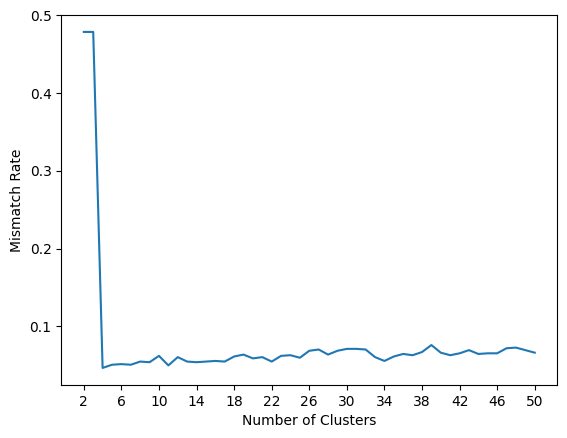

Cluster 4 has the lowest mismatch rate of  0.0466


In [15]:

for i in range(len(overall_mismatch_rate_list)):
    print(i+2," clusters")
    print("Overall mismatch rate:", round(overall_mismatch_rate_list[i],4),'\n')

plt.plot(range(2, 51), overall_mismatch_rate_list)
plt.xticks(range(2, 51,4))
plt.xlabel("Number of Clusters")
plt.ylabel("Mismatch Rate")
plt.show()
print("Cluster", np.argmin(overall_mismatch_rate_list)+2,"has the lowest mismatch rate of ",round( min(overall_mismatch_rate_list),4))